In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from sklearn.metrics import mean_absolute_error

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7) (동해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12) (서해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4) (남해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 동해 서해 남해 
        if i <8:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 0
            only_train_dataset[i]['S'] = 1
        else:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 1
            only_train_dataset[i]['S'] = 0
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_wind_x'] = only_train_dataset[i]['wind_x'].diff() 
        only_train_dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_wind_y'] = only_train_dataset[i]['wind_y'].diff()
        only_train_dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_water_velocity_x'] = only_train_dataset[i]['water_velocity_x'].diff() 
        only_train_dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_water_velocity_y'] = only_train_dataset[i]['water_velocity_y'].diff() 
        only_train_dataset[i]['diff_water_velocity_y'][0] = 0
        
        # 초기 이동 고려 (원-핫 인코딩)
        only_train_dataset[i]['initial'] = 0
        only_train_dataset[i]['not_initial'] = 0
        for j in range(0,10):
            only_train_dataset[i]['not_initial'][j] = 0
            only_train_dataset[i]['initial'][j] = 1
        
        # 
        only_train_dataset[i]['water_velocity_x_10'] = only_train_dataset[i]['water_velocity_x'] * 10
        only_train_dataset[i]['water_velocity_y_10'] = only_train_dataset[i]['water_velocity_y'] * 10
        
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        only_train_dataset[i]['diff'] = only_train_dataset[i]['diff'].shift(1)
        
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 동해 서해 남해 
        if i <7:
            dataset[i]['E'] = 1
            dataset[i]['W'] = 0
            dataset[i]['S'] = 0
        elif i >= 7 and i<18:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 1
            dataset[i]['S'] = 0
        else:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 0
            dataset[i]['S'] = 1
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_wind_x'] = dataset[i]['wind_x'].diff() 
        dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_wind_y'] = dataset[i]['wind_y'].diff()
        dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_water_velocity_x'] = dataset[i]['water_velocity_x'].diff() 
        dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_water_velocity_y'] = dataset[i]['water_velocity_y'].diff() 
        dataset[i]['diff_water_velocity_y'][0] = 0
        
        # 초기 이동 고려 (원-핫 인코딩)
        dataset[i]['initial'] = 0
        dataset[i]['not_initial'] = 1
        for j in range(0,30):
            dataset[i]['not_initial'][j] = 0
            dataset[i]['initial'][j] = 1
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        dataset[i]['diff'] = dataset[i]['diff'].shift(1)
        # Null 값 제외
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

In [2]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_wind_x'][0] = 0
C

C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_wind_x'][0] = 0
C

C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_26792\1324764507.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

--------------------- Model  0  ----------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 40        
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0503 - mae: 0.1601
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0170 - mae: 0.0965
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0086 - mae: 0.0693
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0051 - mae: 0.0530
Epoch 5/100
96/96 [====

96/96 [==============================] - 0s 1ms/step - loss: 1.0717e-04 - mae: 0.0082
Epoch 52/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0418e-04 - mae: 0.0080
Epoch 53/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0618e-04 - mae: 0.0081
Epoch 54/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0385e-04 - mae: 0.0080
Epoch 55/100
96/96 [==============================] - 0s 2ms/step - loss: 1.0499e-04 - mae: 0.0081
Epoch 56/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0612e-04 - mae: 0.0081
Epoch 57/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0458e-04 - mae: 0.0081
Epoch 58/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0382e-04 - mae: 0.0080
Epoch 59/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0487e-04 - mae: 0.0080
Epoch 60/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0306e-04 - mae: 0.0080
Epoch 61/100
96/96 [===

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 40        
                                                                 
 dense_15 (Dense)            (None, 2)                 18        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
96/96 [==============================] - 1s 1ms/step - loss: 0.1090 - mae: 0.2302
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0330 - mae: 0.1348
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0164 - mae: 0.0989
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0096 - mae: 0.0760
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.006

96/96 [==============================] - 0s 1ms/step - loss: 1.5391e-04 - mae: 0.0096
Epoch 46/100
96/96 [==============================] - 0s 1ms/step - loss: 1.4683e-04 - mae: 0.0094
Epoch 47/100
96/96 [==============================] - 0s 1ms/step - loss: 1.3856e-04 - mae: 0.0092
Epoch 48/100
96/96 [==============================] - 0s 1ms/step - loss: 1.3283e-04 - mae: 0.0090
Epoch 49/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2812e-04 - mae: 0.0088
Epoch 50/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2482e-04 - mae: 0.0087
Epoch 51/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2041e-04 - mae: 0.0085
Epoch 52/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1703e-04 - mae: 0.0084
Epoch 53/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1374e-04 - mae: 0.0083
Epoch 54/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1104e-04 - mae: 0.0082
Epoch 55/100
96/96 [===

 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 40        
                                                                 
 dense_21 (Dense)            (None, 2)                 18        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
96/96 [==============================] - 1s 1ms/step - loss: 0.1824 - mae: 0.2891
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0603 - mae: 0.1697
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0299 - mae: 0.1251
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0178 - mae: 0.0972
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0115 - mae: 0.0784
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss:

96/96 [==============================] - 0s 1ms/step - loss: 1.2762e-04 - mae: 0.0088
Epoch 54/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2685e-04 - mae: 0.0088
Epoch 55/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2609e-04 - mae: 0.0088
Epoch 56/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2641e-04 - mae: 0.0088
Epoch 57/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2687e-04 - mae: 0.0088
Epoch 58/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2603e-04 - mae: 0.0088
Epoch 59/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2687e-04 - mae: 0.0088
Epoch 60/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2599e-04 - mae: 0.0088
Epoch 61/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2622e-04 - mae: 0.0088
Epoch 62/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2653e-04 - mae: 0.0088
Epoch 63/100
96/96 [===

96/96 [==============================] - 0s 1ms/step - loss: 1.6656e-04 - mae: 0.0099
Epoch 29/100
96/96 [==============================] - 0s 1ms/step - loss: 1.6060e-04 - mae: 0.0098
Epoch 30/100
96/96 [==============================] - 0s 1ms/step - loss: 1.5496e-04 - mae: 0.0096
Epoch 31/100
96/96 [==============================] - 0s 1ms/step - loss: 1.4955e-04 - mae: 0.0095
Epoch 32/100
96/96 [==============================] - 0s 1ms/step - loss: 1.4469e-04 - mae: 0.0094
Epoch 33/100
96/96 [==============================] - 0s 1ms/step - loss: 1.4068e-04 - mae: 0.0092
Epoch 34/100
96/96 [==============================] - 0s 1ms/step - loss: 1.3641e-04 - mae: 0.0091
Epoch 35/100
96/96 [==============================] - 0s 1ms/step - loss: 1.3280e-04 - mae: 0.0090
Epoch 36/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2945e-04 - mae: 0.0089
Epoch 37/100
96/96 [==============================] - 0s 1ms/step - loss: 1.2686e-04 - mae: 0.0089
Epoch 38/100
96/96 [===

96/96 [==============================] - 0s 1ms/step - loss: 1.1068e-04 - mae: 0.0083
Epoch 86/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1156e-04 - mae: 0.0083
Epoch 87/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1026e-04 - mae: 0.0083
Epoch 88/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1048e-04 - mae: 0.0083
Epoch 89/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0937e-04 - mae: 0.0082
Epoch 90/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1040e-04 - mae: 0.0083
Epoch 91/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0992e-04 - mae: 0.0082
Epoch 92/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1050e-04 - mae: 0.0083
Epoch 93/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0962e-04 - mae: 0.0082
Epoch 94/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0950e-04 - mae: 0.0082
Epoch 95/100
96/96 [===

96/96 [==============================] - 0s 1ms/step - loss: 2.9786e-04 - mae: 0.0134
Epoch 36/100
96/96 [==============================] - 0s 1ms/step - loss: 2.8053e-04 - mae: 0.0130
Epoch 37/100
96/96 [==============================] - 0s 1ms/step - loss: 2.6510e-04 - mae: 0.0127
Epoch 38/100
96/96 [==============================] - 0s 1ms/step - loss: 2.5297e-04 - mae: 0.0124
Epoch 39/100
96/96 [==============================] - 0s 1ms/step - loss: 2.4030e-04 - mae: 0.0121
Epoch 40/100
96/96 [==============================] - 0s 1ms/step - loss: 2.3030e-04 - mae: 0.0119
Epoch 41/100
96/96 [==============================] - 0s 1ms/step - loss: 2.2061e-04 - mae: 0.0116
Epoch 42/100
96/96 [==============================] - 0s 1ms/step - loss: 2.1310e-04 - mae: 0.0115
Epoch 43/100
96/96 [==============================] - 0s 1ms/step - loss: 2.0493e-04 - mae: 0.0113
Epoch 44/100
96/96 [==============================] - 0s 2ms/step - loss: 1.9829e-04 - mae: 0.0111
Epoch 45/100
96/96 [===

Epoch 10/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0060 - mae: 0.0602
Epoch 11/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0050 - mae: 0.0550
Epoch 12/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0042 - mae: 0.0503
Epoch 13/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0035 - mae: 0.0461
Epoch 14/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0420
Epoch 15/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0025 - mae: 0.0386
Epoch 16/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0357
Epoch 17/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0321
Epoch 18/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0296
Epoch 19/100
97/97 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0271
Epoch 20/100
97/97 [==============================

96/96 [==============================] - 0s 1ms/step - loss: 9.9602e-05 - mae: 0.0078
Epoch 69/100
96/96 [==============================] - 0s 1ms/step - loss: 9.9513e-05 - mae: 0.0078
Epoch 70/100
96/96 [==============================] - 0s 1ms/step - loss: 9.8107e-05 - mae: 0.0077
Epoch 71/100
96/96 [==============================] - 0s 1ms/step - loss: 9.9319e-05 - mae: 0.0078
Epoch 72/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0011e-04 - mae: 0.0079
Epoch 73/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0185e-04 - mae: 0.0079
Epoch 74/100
96/96 [==============================] - 0s 1ms/step - loss: 9.8534e-05 - mae: 0.0078
Epoch 75/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0139e-04 - mae: 0.0079
Epoch 76/100
96/96 [==============================] - 0s 1ms/step - loss: 9.7525e-05 - mae: 0.0077
Epoch 77/100
96/96 [==============================] - 0s 1ms/step - loss: 9.9298e-05 - mae: 0.0078
Epoch 78/100
96/96 [===

96/96 [==============================] - 0s 1ms/step - loss: 1.0438e-04 - mae: 0.0080
Epoch 44/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0479e-04 - mae: 0.0080
Epoch 45/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0449e-04 - mae: 0.0080
Epoch 46/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0476e-04 - mae: 0.0080
Epoch 47/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0371e-04 - mae: 0.0080
Epoch 48/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0452e-04 - mae: 0.0080
Epoch 49/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0278e-04 - mae: 0.0080
Epoch 50/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0296e-04 - mae: 0.0080
Epoch 51/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0300e-04 - mae: 0.0080
Epoch 52/100
96/96 [==============================] - 0s 1ms/step - loss: 1.0249e-04 - mae: 0.0080
Epoch 53/100
96/96 [===

3/3 [==============================] - 0s 3ms/step
0.15356726200616183
0.3930515852359012
--------------------- Model  16  ----------------------
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 8)                 40        
                                                                 
 dense_41 (Dense)            (None, 2)                 18        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
96/96 [==============================] - 1s 1ms/step - loss: 0.1700 - mae: 0.3062
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0484 - mae: 0.1581
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0166 - mae: 0.0953
Epoch 4/100
96/96 [======

96/96 [==============================] - 0s 1ms/step - loss: 1.1218e-04 - mae: 0.0083
Epoch 77/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1232e-04 - mae: 0.0083
Epoch 78/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1194e-04 - mae: 0.0083
Epoch 79/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1168e-04 - mae: 0.0083
Epoch 80/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1164e-04 - mae: 0.0083
Epoch 81/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1162e-04 - mae: 0.0083
Epoch 82/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1316e-04 - mae: 0.0084
Epoch 83/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1327e-04 - mae: 0.0084
Epoch 84/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1482e-04 - mae: 0.0084
Epoch 85/100
96/96 [==============================] - 0s 1ms/step - loss: 1.1278e-04 - mae: 0.0084
Epoch 86/100
96/96 [===

96/96 [==============================] - 0s 1ms/step - loss: 4.6055e-04 - mae: 0.0151
Epoch 27/100
96/96 [==============================] - 0s 1ms/step - loss: 4.1104e-04 - mae: 0.0145
Epoch 28/100
96/96 [==============================] - 0s 1ms/step - loss: 3.6943e-04 - mae: 0.0138
Epoch 29/100
96/96 [==============================] - 0s 1ms/step - loss: 3.3354e-04 - mae: 0.0132
Epoch 30/100
96/96 [==============================] - 0s 1ms/step - loss: 3.0442e-04 - mae: 0.0127
Epoch 31/100
96/96 [==============================] - 0s 2ms/step - loss: 2.7781e-04 - mae: 0.0122
Epoch 32/100
96/96 [==============================] - 0s 1ms/step - loss: 2.5571e-04 - mae: 0.0118
Epoch 33/100
96/96 [==============================] - 0s 1ms/step - loss: 2.3804e-04 - mae: 0.0115
Epoch 34/100
96/96 [==============================] - 0s 1ms/step - loss: 2.2323e-04 - mae: 0.0112
Epoch 35/100
96/96 [==============================] - 0s 1ms/step - loss: 2.1085e-04 - mae: 0.0110
Epoch 36/100
96/96 [===

Epoch 1/100
96/96 [==============================] - 1s 1ms/step - loss: 0.2629 - mae: 0.3446
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1033 - mae: 0.2093
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0504 - mae: 0.1476
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0285 - mae: 0.1130
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0183 - mae: 0.0930
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0129 - mae: 0.0797
Epoch 7/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0096 - mae: 0.0698
Epoch 8/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0074 - mae: 0.0617
Epoch 9/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0058 - mae: 0.0552
Epoch 10/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0046 - mae: 0.0493
Epoch 11/100
96/96 [==============================] - 0s 1m

92/92 [==============================] - 0s 1ms/step - loss: 1.0855e-04 - mae: 0.0081
Epoch 60/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0648e-04 - mae: 0.0080
Epoch 61/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0638e-04 - mae: 0.0080
Epoch 62/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0654e-04 - mae: 0.0080
Epoch 63/100
92/92 [==============================] - 0s 2ms/step - loss: 1.0552e-04 - mae: 0.0080
Epoch 64/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0495e-04 - mae: 0.0079
Epoch 65/100
92/92 [==============================] - 0s 2ms/step - loss: 1.0481e-04 - mae: 0.0080
Epoch 66/100
92/92 [==============================] - 0s 2ms/step - loss: 1.0339e-04 - mae: 0.0079
Epoch 67/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0446e-04 - mae: 0.0079
Epoch 68/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0295e-04 - mae: 0.0079
Epoch 69/100
92/92 [===

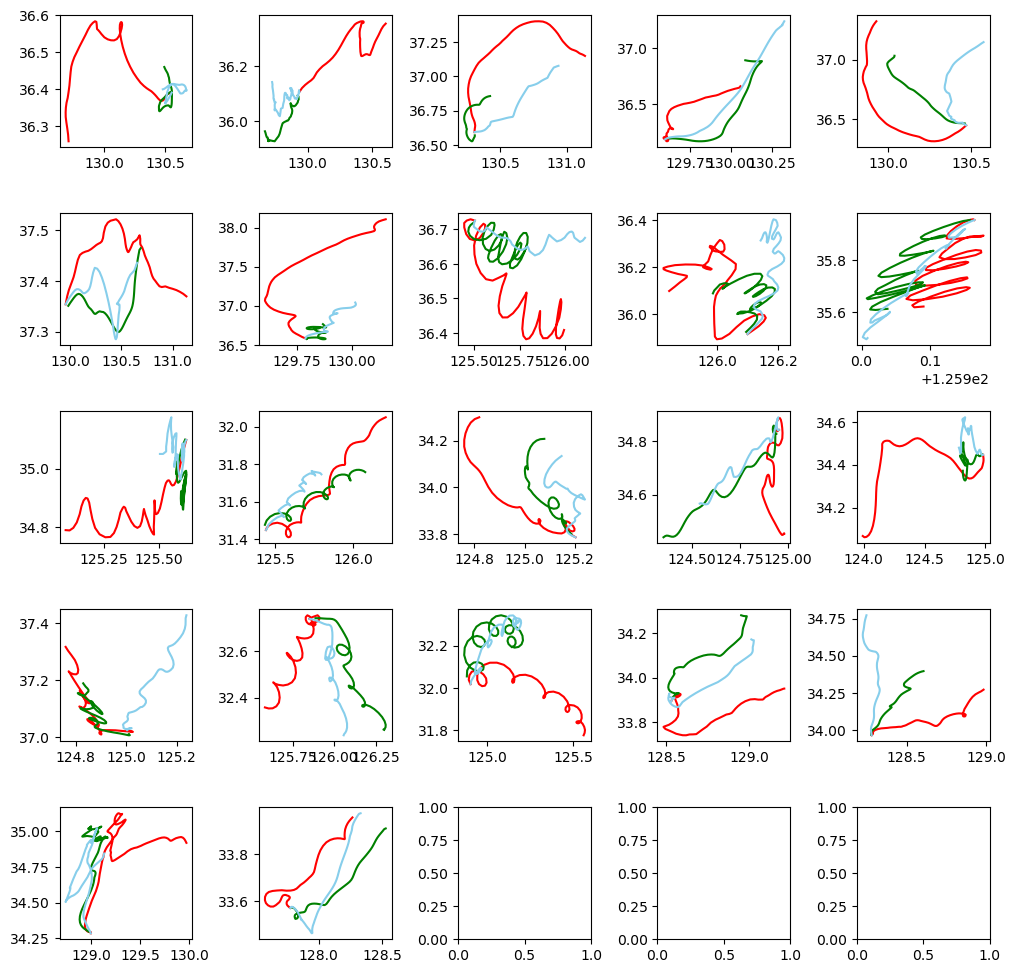

In [5]:
# MLP (activation relu) & MinMax scaler
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X) 
    
    MLP = tf.keras.Sequential([
    Dense(units = 8, input_dim = 4, activation = relu)
    ])
    MLP.add(Dense(units = 2))
    MLP.summary()
    MLP.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP.fit(train_X, train_y, epochs = 100, batch_size = 16)
    
    # model save
#     MLP.save(str(i)+'MLP_model.h5')

    # Predict
    y_pred = MLP.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print(drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print(NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [ ]:
# MLP특성 4
mae_sum = 0 
baseline_mae_sum = 0
NCLS_sum = 0
baseline_NCLS_sum = 0

for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    baseline_mae_sum += baseline_MAE_list[i]
    NCLS_sum += NCLS_list[i]
    baseline_NCLS_sum += baseline_NCLS_list[i]

# 라이브러리 Mae    
print ('Model Mae : ', mae_sum/len(dataset) )
print ('Baseline Mae : ', baseline_mae_sum/len(dataset) )
print ('Model NCLS : ', NCLS_sum/len(dataset) )
print ('Baseline NCLS : ', baseline_NCLS_sum/len(dataset) )

In [6]:
MLP_mae_sum = 0
MLP_NCLS_sum = 0
for i in range(len(dataset)):
    MLP_mae_sum += MAE_list[i]
    MLP_NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', MLP_mae_sum/len(dataset) )
print ('평균 NCLS : ', MLP_NCLS_sum/len(dataset) )

평균 Mae :  0.20054377569992365
평균 NCLS :  0.4605954038300094


--------------------- Model  0  ----------------------
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 8)                 40        
                                                                 
 dense_160 (Dense)           (None, 4)                 36        
                                                                 
 dense_161 (Dense)           (None, 2)                 10        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
50/50 [==============================] - 1s 1ms/step - loss: 0.3326 - mae: 0.3554
Epoch 2/120
50/50 [==============================] - 0s 1ms/step - loss: 0.1435 - mae: 0.2145
Epoch 3/120
50/50 [==============================] - 0s 1ms/step - loss: 0.074

50/50 [==============================] - 0s 1ms/step - loss: 1.8627e-04 - mae: 0.0108
Epoch 77/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8536e-04 - mae: 0.0108
Epoch 78/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8453e-04 - mae: 0.0107
Epoch 79/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8383e-04 - mae: 0.0108
Epoch 80/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8330e-04 - mae: 0.0107
Epoch 81/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8261e-04 - mae: 0.0107
Epoch 82/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8160e-04 - mae: 0.0107
Epoch 83/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8110e-04 - mae: 0.0107
Epoch 84/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8069e-04 - mae: 0.0107
Epoch 85/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8030e-04 - mae: 0.0107
Epoch 86/120
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: 1.3179e-04 - mae: 0.0090
Epoch 112/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3156e-04 - mae: 0.0090
Epoch 113/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3069e-04 - mae: 0.0090
Epoch 114/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3149e-04 - mae: 0.0090
Epoch 115/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3033e-04 - mae: 0.0090
Epoch 116/120
50/50 [==============================] - 0s 1ms/step - loss: 1.2974e-04 - mae: 0.0090
Epoch 117/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3043e-04 - mae: 0.0090
Epoch 118/120
50/50 [==============================] - 0s 1ms/step - loss: 1.2893e-04 - mae: 0.0089
Epoch 119/120
50/50 [==============================] - 0s 1ms/step - loss: 1.2915e-04 - mae: 0.0089
Epoch 120/120
3/3 [==============================] - 0s 2ms/step
0.3495113557291936
0.08118739115553375
----------

50/50 [==============================] - 0s 1ms/step - loss: 3.5361e-04 - mae: 0.0137
Epoch 19/120
50/50 [==============================] - 0s 1ms/step - loss: 3.3055e-04 - mae: 0.0133
Epoch 20/120
50/50 [==============================] - 0s 1ms/step - loss: 3.0947e-04 - mae: 0.0130
Epoch 21/120
50/50 [==============================] - 0s 1ms/step - loss: 2.9326e-04 - mae: 0.0128
Epoch 22/120
50/50 [==============================] - 0s 1ms/step - loss: 2.8052e-04 - mae: 0.0127
Epoch 23/120
50/50 [==============================] - 0s 1ms/step - loss: 2.7005e-04 - mae: 0.0125
Epoch 24/120
50/50 [==============================] - 0s 1ms/step - loss: 2.5981e-04 - mae: 0.0123
Epoch 25/120
50/50 [==============================] - 0s 1ms/step - loss: 2.5121e-04 - mae: 0.0122
Epoch 26/120
50/50 [==============================] - 0s 2ms/step - loss: 2.4317e-04 - mae: 0.0121
Epoch 27/120
50/50 [==============================] - 0s 1ms/step - loss: 2.3677e-04 - mae: 0.0120
Epoch 28/120
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: 1.3897e-04 - mae: 0.0092
Epoch 54/120
50/50 [==============================] - 0s 2ms/step - loss: 1.3863e-04 - mae: 0.0092
Epoch 55/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3814e-04 - mae: 0.0092
Epoch 56/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3743e-04 - mae: 0.0092
Epoch 57/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3695e-04 - mae: 0.0091
Epoch 58/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3653e-04 - mae: 0.0091
Epoch 59/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3597e-04 - mae: 0.0091
Epoch 60/120
50/50 [==============================] - 0s 2ms/step - loss: 1.3556e-04 - mae: 0.0091
Epoch 61/120
50/50 [==============================] - 0s 2ms/step - loss: 1.3533e-04 - mae: 0.0091
Epoch 62/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3495e-04 - mae: 0.0091
Epoch 63/120
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: 1.7673e-04 - mae: 0.0108
Epoch 90/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7648e-04 - mae: 0.0107
Epoch 91/120
50/50 [==============================] - 1s 12ms/step - loss: 1.7638e-04 - mae: 0.0107
Epoch 92/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7631e-04 - mae: 0.0107
Epoch 93/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7631e-04 - mae: 0.0107
Epoch 94/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7605e-04 - mae: 0.0107
Epoch 95/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7587e-04 - mae: 0.0107
Epoch 96/120
50/50 [==============================] - 0s 2ms/step - loss: 1.7637e-04 - mae: 0.0107
Epoch 97/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7590e-04 - mae: 0.0107
Epoch 98/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7594e-04 - mae: 0.0107
Epoch 99/120
50/50 [==

 dense_180 (Dense)           (None, 8)                 40        
                                                                 
 dense_181 (Dense)           (None, 4)                 36        
                                                                 
 dense_182 (Dense)           (None, 2)                 10        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
50/50 [==============================] - 1s 1ms/step - loss: 0.0588 - mae: 0.1700
Epoch 2/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0174 - mae: 0.0959
Epoch 3/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0091 - mae: 0.0732
Epoch 4/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0063 - mae: 0.0621
Epoch 5/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0047 - mae: 0.0536
Epoch 

50/50 [==============================] - 0s 1ms/step - loss: 1.7094e-04 - mae: 0.0103
Epoch 32/120
50/50 [==============================] - 0s 1ms/step - loss: 1.6726e-04 - mae: 0.0101
Epoch 33/120
50/50 [==============================] - 0s 1ms/step - loss: 1.6461e-04 - mae: 0.0101
Epoch 34/120
50/50 [==============================] - 0s 2ms/step - loss: 1.6264e-04 - mae: 0.0100
Epoch 35/120
50/50 [==============================] - 0s 3ms/step - loss: 1.5956e-04 - mae: 0.0099
Epoch 36/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5748e-04 - mae: 0.0098
Epoch 37/120
50/50 [==============================] - 0s 3ms/step - loss: 1.5503e-04 - mae: 0.0098
Epoch 38/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5354e-04 - mae: 0.0097
Epoch 39/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5150e-04 - mae: 0.0096
Epoch 40/120
50/50 [==============================] - 0s 2ms/step - loss: 1.4976e-04 - mae: 0.0096
Epoch 41/120
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: 2.1161e-04 - mae: 0.0111
Epoch 68/120
50/50 [==============================] - 0s 2ms/step - loss: 2.0861e-04 - mae: 0.0111
Epoch 69/120
50/50 [==============================] - 0s 2ms/step - loss: 2.0659e-04 - mae: 0.0111
Epoch 70/120
50/50 [==============================] - 0s 2ms/step - loss: 2.0433e-04 - mae: 0.0110
Epoch 71/120
50/50 [==============================] - 0s 2ms/step - loss: 2.0185e-04 - mae: 0.0110
Epoch 72/120
50/50 [==============================] - 0s 2ms/step - loss: 1.9989e-04 - mae: 0.0110
Epoch 73/120
50/50 [==============================] - 0s 2ms/step - loss: 1.9779e-04 - mae: 0.0110
Epoch 74/120
50/50 [==============================] - 0s 2ms/step - loss: 1.9601e-04 - mae: 0.0109
Epoch 75/120
50/50 [==============================] - 0s 2ms/step - loss: 1.9446e-04 - mae: 0.0109
Epoch 76/120
50/50 [==============================] - 0s 2ms/step - loss: 1.9267e-04 - mae: 0.0109
Epoch 77/120
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: 1.6316e-04 - mae: 0.0102
Epoch 103/120
50/50 [==============================] - 0s 1ms/step - loss: 1.6088e-04 - mae: 0.0101
Epoch 104/120
50/50 [==============================] - 0s 2ms/step - loss: 1.6005e-04 - mae: 0.0101
Epoch 105/120
50/50 [==============================] - 0s 2ms/step - loss: 1.6083e-04 - mae: 0.0101
Epoch 106/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5728e-04 - mae: 0.0100
Epoch 107/120
50/50 [==============================] - 0s 1ms/step - loss: 1.5835e-04 - mae: 0.0101
Epoch 108/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5621e-04 - mae: 0.0100
Epoch 109/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5570e-04 - mae: 0.0100
Epoch 110/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5470e-04 - mae: 0.0099
Epoch 111/120
50/50 [==============================] - 0s 2ms/step - loss: 1.5452e-04 - mae: 0.0100
Epoch 112/120


50/50 [==============================] - 0s 1ms/step - loss: 5.8181e-04 - mae: 0.0156
Epoch 9/120
50/50 [==============================] - 0s 1ms/step - loss: 4.4232e-04 - mae: 0.0141
Epoch 10/120
50/50 [==============================] - 0s 2ms/step - loss: 3.5468e-04 - mae: 0.0132
Epoch 11/120
50/50 [==============================] - 0s 1ms/step - loss: 2.9668e-04 - mae: 0.0125
Epoch 12/120
50/50 [==============================] - 0s 1ms/step - loss: 2.6030e-04 - mae: 0.0121
Epoch 13/120
50/50 [==============================] - 0s 2ms/step - loss: 2.3507e-04 - mae: 0.0117
Epoch 14/120
50/50 [==============================] - 0s 1ms/step - loss: 2.1831e-04 - mae: 0.0115
Epoch 15/120
50/50 [==============================] - 0s 1ms/step - loss: 2.0722e-04 - mae: 0.0113
Epoch 16/120
50/50 [==============================] - 0s 1ms/step - loss: 2.0014e-04 - mae: 0.0111
Epoch 17/120
50/50 [==============================] - 0s 1ms/step - loss: 1.9576e-04 - mae: 0.0111
Epoch 18/120
50/50 [====

50/50 [==============================] - 0s 1ms/step - loss: 1.8311e-04 - mae: 0.0109
Epoch 44/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8318e-04 - mae: 0.0109
Epoch 45/120
50/50 [==============================] - 0s 2ms/step - loss: 1.8256e-04 - mae: 0.0109
Epoch 46/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8259e-04 - mae: 0.0109
Epoch 47/120
50/50 [==============================] - 0s 2ms/step - loss: 1.8247e-04 - mae: 0.0109
Epoch 48/120
50/50 [==============================] - 0s 2ms/step - loss: 1.8204e-04 - mae: 0.0109
Epoch 49/120
50/50 [==============================] - 0s 2ms/step - loss: 1.8207e-04 - mae: 0.0109
Epoch 50/120
50/50 [==============================] - 0s 2ms/step - loss: 1.8174e-04 - mae: 0.0109
Epoch 51/120
50/50 [==============================] - 0s 2ms/step - loss: 1.8165e-04 - mae: 0.0109
Epoch 52/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8161e-04 - mae: 0.0109
Epoch 53/120
50/50 [===

 dense_202 (Dense)           (None, 4)                 36        
                                                                 
 dense_203 (Dense)           (None, 2)                 10        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
50/50 [==============================] - 1s 3ms/step - loss: 0.0993 - mae: 0.2045
Epoch 2/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0337 - mae: 0.1183
Epoch 3/120
50/50 [==============================] - 0s 5ms/step - loss: 0.0173 - mae: 0.0907
Epoch 4/120
50/50 [==============================] - 0s 3ms/step - loss: 0.0109 - mae: 0.0752
Epoch 5/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0074 - mae: 0.0613
Epoch 6/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0052 - mae: 0.0501
Epoch 7/120
50/50 [=========================

50/50 [==============================] - 0s 2ms/step - loss: 3.5601e-04 - mae: 0.0135
Epoch 33/120
50/50 [==============================] - 0s 2ms/step - loss: 3.3662e-04 - mae: 0.0132
Epoch 34/120
50/50 [==============================] - 0s 1ms/step - loss: 3.1852e-04 - mae: 0.0128
Epoch 35/120
50/50 [==============================] - 0s 1ms/step - loss: 3.0256e-04 - mae: 0.0126
Epoch 36/120
50/50 [==============================] - 0s 1ms/step - loss: 2.8824e-04 - mae: 0.0123
Epoch 37/120
50/50 [==============================] - 0s 2ms/step - loss: 2.7560e-04 - mae: 0.0121
Epoch 38/120
50/50 [==============================] - 0s 2ms/step - loss: 2.6374e-04 - mae: 0.0119
Epoch 39/120
50/50 [==============================] - 0s 2ms/step - loss: 2.5336e-04 - mae: 0.0117
Epoch 40/120
50/50 [==============================] - 0s 1ms/step - loss: 2.4406e-04 - mae: 0.0115
Epoch 41/120
50/50 [==============================] - 0s 1ms/step - loss: 2.3566e-04 - mae: 0.0114
Epoch 42/120
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: 1.3174e-04 - mae: 0.0090
Epoch 68/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3110e-04 - mae: 0.0090
Epoch 69/120
50/50 [==============================] - 0s 1ms/step - loss: 1.3054e-04 - mae: 0.0090
Epoch 70/120
50/50 [==============================] - 0s 1ms/step - loss: 1.2996e-04 - mae: 0.0090
Epoch 71/120
50/50 [==============================] - 0s 2ms/step - loss: 1.2942e-04 - mae: 0.0090
Epoch 72/120
50/50 [==============================] - 0s 2ms/step - loss: 1.2857e-04 - mae: 0.0089
Epoch 73/120
50/50 [==============================] - 0s 1ms/step - loss: 1.2678e-04 - mae: 0.0089
Epoch 74/120
50/50 [==============================] - 0s 1ms/step - loss: 1.2644e-04 - mae: 0.0089
Epoch 75/120
50/50 [==============================] - 0s 2ms/step - loss: 1.2563e-04 - mae: 0.0089
Epoch 76/120
50/50 [==============================] - 0s 2ms/step - loss: 1.2508e-04 - mae: 0.0088
Epoch 77/120
50/50 [===

Epoch 103/120
50/50 [==============================] - 0s 2ms/step - loss: 1.7347e-04 - mae: 0.0106
Epoch 104/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7236e-04 - mae: 0.0106
Epoch 105/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7243e-04 - mae: 0.0106
Epoch 106/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7265e-04 - mae: 0.0106
Epoch 107/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7250e-04 - mae: 0.0106
Epoch 108/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7228e-04 - mae: 0.0106
Epoch 109/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7190e-04 - mae: 0.0106
Epoch 110/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7147e-04 - mae: 0.0105
Epoch 111/120
50/50 [==============================] - 0s 2ms/step - loss: 1.7207e-04 - mae: 0.0106
Epoch 112/120
50/50 [==============================] - 0s 1ms/step - loss: 1.7245e-04 - mae: 0.0106


50/50 [==============================] - 0s 1ms/step - loss: 0.0042 - mae: 0.0375
Epoch 10/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0033 - mae: 0.0336
Epoch 11/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0026 - mae: 0.0305
Epoch 12/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0281
Epoch 13/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0264
Epoch 14/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0251
Epoch 15/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0238
Epoch 16/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0228
Epoch 17/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0218
Epoch 18/120
50/50 [==============================] - 0s 2ms/step - loss: 9.6663e-04 - mae: 0.0210
Epoch 19/120
50/50 [==============================] - 0s 2m

50/50 [==============================] - 0s 1ms/step - loss: 1.9244e-04 - mae: 0.0111
Epoch 46/120
50/50 [==============================] - 0s 1ms/step - loss: 1.9101e-04 - mae: 0.0111
Epoch 47/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8975e-04 - mae: 0.0111
Epoch 48/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8861e-04 - mae: 0.0111
Epoch 49/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8759e-04 - mae: 0.0110
Epoch 50/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8663e-04 - mae: 0.0110
Epoch 51/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8588e-04 - mae: 0.0110
Epoch 52/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8553e-04 - mae: 0.0110
Epoch 53/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8476e-04 - mae: 0.0110
Epoch 54/120
50/50 [==============================] - 0s 1ms/step - loss: 1.8423e-04 - mae: 0.0110
Epoch 55/120
50/50 [===

                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
50/50 [==============================] - 1s 1ms/step - loss: 0.0626 - mae: 0.1249
Epoch 2/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0222 - mae: 0.0819
Epoch 3/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0108 - mae: 0.0611
Epoch 4/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0470
Epoch 5/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0363
Epoch 6/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0273
Epoch 7/120
50/50 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0210
Epoch 8/120
50/50 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0172
Epoch 9/120
50/50 [==============================] - 0

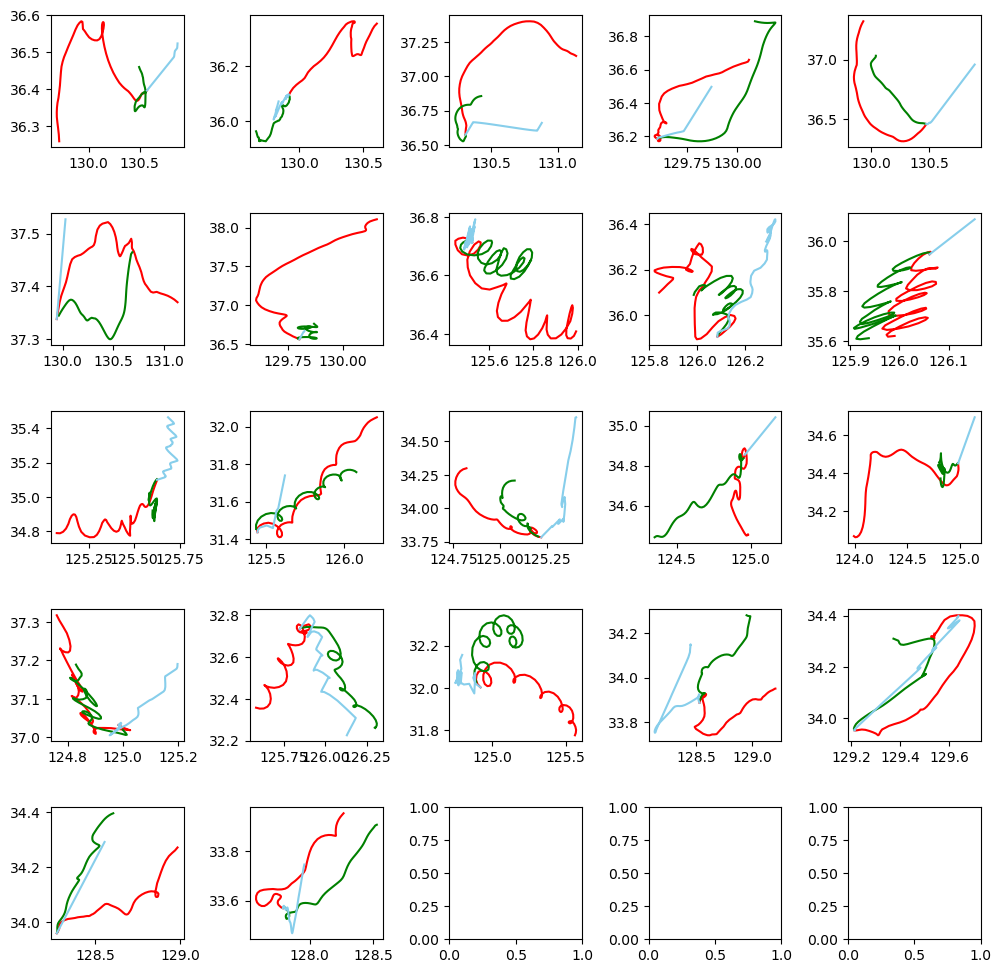

In [28]:
import sys
# MLP (activation relu) & roburst scaler & 특성 4
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)  
    MLP = tf.keras.Sequential([
    Dense(units = 8, input_dim = 4, activation = relu)
    ])
    MLP.add(Dense(units = 4, activation = relu))
    MLP.add(Dense(units = 2))
    MLP.summary()
    MLP.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP.fit(train_X, train_y, epochs = 120, batch_size = 30)
    
    # model save
    MLP.save(str(i)+'MLP_model.h5')

    # Predict
    y_pred = MLP.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print(drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print(NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [ ]:
# MLP (activation relu) & roburst scaler & 특성 4
MLP_mae_sum = 0
MLP_NCLS_sum = 0
for i in range(len(dataset)):
    MLP_mae_sum += MAE_list[i]
    MLP_NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', MLP_mae_sum/len(dataset) )
print ('평균 NCLS : ', MLP_NCLS_sum/len(dataset) )

In [12]:
len(only_train_dataset)

15

--------------------- Model  0  ----------------------
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_333 (Dense)           (None, 40)                200       
                                                                 
 dense_334 (Dense)           (None, 20)                820       
                                                                 
 dense_335 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
141/141 [==============================] - 1s 1ms/step - loss: 0.0021 - mae: 0.0316
Epoch 2/80
141/141 [==============================] - 0s 1ms/step - loss: 4.0094e-04 - mae: 0.0153
Epoch 3/80
141/141 [==============================] - 0s 1ms/step

141/141 [==============================] - 0s 1ms/step - loss: 6.5109e-05 - mae: 0.0061
Epoch 67/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0620e-05 - mae: 0.0059
Epoch 68/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0211e-05 - mae: 0.0058
Epoch 69/80
141/141 [==============================] - 0s 1ms/step - loss: 5.8842e-05 - mae: 0.0058
Epoch 70/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1356e-05 - mae: 0.0059
Epoch 71/80
141/141 [==============================] - 0s 1ms/step - loss: 5.8835e-05 - mae: 0.0058
Epoch 72/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0248e-05 - mae: 0.0059
Epoch 73/80
141/141 [==============================] - 0s 1ms/step - loss: 5.8007e-05 - mae: 0.0058
Epoch 74/80
141/141 [==============================] - 0s 1ms/step - loss: 5.8178e-05 - mae: 0.0057
Epoch 75/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0778e-05 - mae: 0.0059
Epoch 76/80


141/141 [==============================] - 0s 1ms/step - loss: 6.3327e-05 - mae: 0.0060
Epoch 51/80
141/141 [==============================] - 0s 1ms/step - loss: 6.2640e-05 - mae: 0.0060
Epoch 52/80
141/141 [==============================] - 0s 1ms/step - loss: 6.2521e-05 - mae: 0.0060
Epoch 53/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1729e-05 - mae: 0.0059
Epoch 54/80
141/141 [==============================] - 0s 1ms/step - loss: 6.2897e-05 - mae: 0.0060
Epoch 55/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4900e-05 - mae: 0.0061
Epoch 56/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4206e-05 - mae: 0.0061
Epoch 57/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5096e-05 - mae: 0.0061
Epoch 58/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1900e-05 - mae: 0.0059
Epoch 59/80
141/141 [==============================] - 0s 1ms/step - loss: 6.3873e-05 - mae: 0.0060
Epoch 60/80


141/141 [==============================] - 0s 1ms/step - loss: 6.7513e-05 - mae: 0.0063
Epoch 35/80
141/141 [==============================] - 0s 2ms/step - loss: 6.2668e-05 - mae: 0.0060
Epoch 36/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1699e-05 - mae: 0.0060
Epoch 37/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4389e-05 - mae: 0.0061
Epoch 38/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1890e-05 - mae: 0.0059
Epoch 39/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1600e-05 - mae: 0.0059
Epoch 40/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1200e-05 - mae: 0.0059
Epoch 41/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1470e-05 - mae: 0.0059
Epoch 42/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0889e-05 - mae: 0.0059
Epoch 43/80
141/141 [==============================] - 0s 1ms/step - loss: 5.9906e-05 - mae: 0.0058
Epoch 44/80


141/141 [==============================] - 0s 1ms/step - loss: 7.1044e-05 - mae: 0.0064
Epoch 19/80
141/141 [==============================] - 0s 1ms/step - loss: 7.4091e-05 - mae: 0.0065
Epoch 20/80
141/141 [==============================] - 0s 1ms/step - loss: 6.9649e-05 - mae: 0.0063
Epoch 21/80
141/141 [==============================] - 0s 1ms/step - loss: 6.8682e-05 - mae: 0.0063
Epoch 22/80
141/141 [==============================] - 0s 1ms/step - loss: 6.9111e-05 - mae: 0.0063
Epoch 23/80
141/141 [==============================] - 0s 1ms/step - loss: 6.9083e-05 - mae: 0.0062
Epoch 24/80
141/141 [==============================] - 0s 1ms/step - loss: 6.8677e-05 - mae: 0.0063
Epoch 25/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5457e-05 - mae: 0.0061
Epoch 26/80
141/141 [==============================] - 0s 1ms/step - loss: 6.6351e-05 - mae: 0.0061
Epoch 27/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4749e-05 - mae: 0.0061
Epoch 28/80


141/141 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0246
Epoch 3/80
141/141 [==============================] - 0s 1ms/step - loss: 5.4178e-04 - mae: 0.0178
Epoch 4/80
141/141 [==============================] - 0s 1ms/step - loss: 3.8345e-04 - mae: 0.0151
Epoch 5/80
141/141 [==============================] - 0s 1ms/step - loss: 3.0092e-04 - mae: 0.0134
Epoch 6/80
141/141 [==============================] - 0s 1ms/step - loss: 2.5488e-04 - mae: 0.0124
Epoch 7/80
141/141 [==============================] - 0s 1ms/step - loss: 2.2127e-04 - mae: 0.0115
Epoch 8/80
141/141 [==============================] - 0s 1ms/step - loss: 1.9761e-04 - mae: 0.0109
Epoch 9/80
141/141 [==============================] - 0s 1ms/step - loss: 1.7687e-04 - mae: 0.0104
Epoch 10/80
141/141 [==============================] - 0s 1ms/step - loss: 1.5952e-04 - mae: 0.0098
Epoch 11/80
141/141 [==============================] - 0s 1ms/step - loss: 1.4926e-04 - mae: 0.0095
Epoch 12/80
141/141 [==

 dense_363 (Dense)           (None, 40)                200       
                                                                 
 dense_364 (Dense)           (None, 20)                820       
                                                                 
 dense_365 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
141/141 [==============================] - 1s 1ms/step - loss: 0.0134 - mae: 0.0622
Epoch 2/80
141/141 [==============================] - 0s 1ms/step - loss: 8.7315e-04 - mae: 0.0216
Epoch 3/80
141/141 [==============================] - 0s 1ms/step - loss: 4.6474e-04 - mae: 0.0160
Epoch 4/80
141/141 [==============================] - 0s 1ms/step - loss: 3.1847e-04 - mae: 0.0135
Epoch 5/80
141/141 [==============================] - 0s 1ms/step - loss: 2.46

141/141 [==============================] - 0s 1ms/step - loss: 5.8679e-05 - mae: 0.0057
Epoch 78/80
141/141 [==============================] - 0s 1ms/step - loss: 5.7720e-05 - mae: 0.0057
Epoch 79/80
141/141 [==============================] - 0s 1ms/step - loss: 5.8109e-05 - mae: 0.0057
Epoch 80/80
3/3 [==============================] - 0s 2ms/step
0.15921486194006787
0.5730239185091126
--------------------- Model  11  ----------------------
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_366 (Dense)           (None, 40)                200       
                                                                 
 dense_367 (Dense)           (None, 20)                820       
                                                                 
 dense_368 (Dense)           (None, 2)                 42        
                                                                 
To

141/141 [==============================] - 0s 1ms/step - loss: 6.9658e-05 - mae: 0.0064
Epoch 62/80
141/141 [==============================] - 0s 2ms/step - loss: 6.7234e-05 - mae: 0.0062
Epoch 63/80
141/141 [==============================] - 0s 2ms/step - loss: 7.0239e-05 - mae: 0.0064
Epoch 64/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5495e-05 - mae: 0.0061
Epoch 65/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5738e-05 - mae: 0.0062
Epoch 66/80
141/141 [==============================] - 0s 1ms/step - loss: 6.6249e-05 - mae: 0.0062
Epoch 67/80
141/141 [==============================] - 0s 1ms/step - loss: 6.3011e-05 - mae: 0.0060
Epoch 68/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5359e-05 - mae: 0.0061
Epoch 69/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4173e-05 - mae: 0.0061
Epoch 70/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5355e-05 - mae: 0.0062
Epoch 71/80


141/141 [==============================] - 0s 1ms/step - loss: 6.1702e-05 - mae: 0.0060
Epoch 46/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1969e-05 - mae: 0.0060
Epoch 47/80
141/141 [==============================] - 0s 1ms/step - loss: 6.2470e-05 - mae: 0.0060
Epoch 48/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1601e-05 - mae: 0.0060
Epoch 49/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0154e-05 - mae: 0.0059
Epoch 50/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1936e-05 - mae: 0.0060
Epoch 51/80
141/141 [==============================] - 0s 1ms/step - loss: 6.2355e-05 - mae: 0.0060
Epoch 52/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1034e-05 - mae: 0.0059
Epoch 53/80
141/141 [==============================] - 0s 1ms/step - loss: 6.0370e-05 - mae: 0.0059
Epoch 54/80
141/141 [==============================] - 0s 1ms/step - loss: 5.9682e-05 - mae: 0.0058
Epoch 55/80


141/141 [==============================] - 0s 2ms/step - loss: 7.0172e-05 - mae: 0.0064
Epoch 30/80
141/141 [==============================] - 0s 2ms/step - loss: 7.5125e-05 - mae: 0.0066
Epoch 31/80
141/141 [==============================] - 0s 2ms/step - loss: 7.2353e-05 - mae: 0.0065
Epoch 32/80
141/141 [==============================] - 0s 1ms/step - loss: 7.2347e-05 - mae: 0.0065
Epoch 33/80
141/141 [==============================] - 0s 1ms/step - loss: 7.1945e-05 - mae: 0.0065
Epoch 34/80
141/141 [==============================] - 0s 1ms/step - loss: 6.9472e-05 - mae: 0.0063
Epoch 35/80
141/141 [==============================] - 0s 1ms/step - loss: 6.8613e-05 - mae: 0.0063
Epoch 36/80
141/141 [==============================] - 0s 1ms/step - loss: 6.8867e-05 - mae: 0.0063
Epoch 37/80
141/141 [==============================] - 0s 2ms/step - loss: 6.6789e-05 - mae: 0.0062
Epoch 38/80
141/141 [==============================] - 0s 2ms/step - loss: 7.1317e-05 - mae: 0.0064
Epoch 39/80


141/141 [==============================] - 0s 1ms/step - loss: 1.2748e-04 - mae: 0.0088
Epoch 14/80
141/141 [==============================] - 0s 1ms/step - loss: 1.2420e-04 - mae: 0.0087
Epoch 15/80
141/141 [==============================] - 0s 1ms/step - loss: 1.1864e-04 - mae: 0.0084
Epoch 16/80
141/141 [==============================] - 0s 1ms/step - loss: 1.1286e-04 - mae: 0.0083
Epoch 17/80
141/141 [==============================] - 0s 1ms/step - loss: 1.0477e-04 - mae: 0.0079
Epoch 18/80
141/141 [==============================] - 0s 1ms/step - loss: 9.9987e-05 - mae: 0.0077
Epoch 19/80
141/141 [==============================] - 0s 1ms/step - loss: 9.6110e-05 - mae: 0.0076
Epoch 20/80
141/141 [==============================] - 0s 1ms/step - loss: 9.6492e-05 - mae: 0.0076
Epoch 21/80
141/141 [==============================] - 0s 1ms/step - loss: 9.2837e-05 - mae: 0.0074
Epoch 22/80
141/141 [==============================] - 0s 1ms/step - loss: 9.4150e-05 - mae: 0.0075
Epoch 23/80


 dense_395 (Dense)           (None, 2)                 42        
                                                                 
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
141/141 [==============================] - 1s 1ms/step - loss: 0.0072 - mae: 0.0529
Epoch 2/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5265e-04 - mae: 0.0196
Epoch 3/80
141/141 [==============================] - 0s 1ms/step - loss: 3.4813e-04 - mae: 0.0143
Epoch 4/80
141/141 [==============================] - 0s 1ms/step - loss: 2.4691e-04 - mae: 0.0121
Epoch 5/80
141/141 [==============================] - 0s 1ms/step - loss: 1.9416e-04 - mae: 0.0108
Epoch 6/80
141/141 [==============================] - 0s 1ms/step - loss: 1.6550e-04 - mae: 0.0099
Epoch 7/80
141/141 [==============================] - 0s 1ms/step - loss: 1.4896e-04 - mae: 0.0094
Epoch 8/80
141/141 [=========================

141/141 [==============================] - 0s 1ms/step - loss: 6.3904e-05 - mae: 0.0060
Epoch 72/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4070e-05 - mae: 0.0061
Epoch 73/80
141/141 [==============================] - 0s 1ms/step - loss: 6.3738e-05 - mae: 0.0061
Epoch 74/80
141/141 [==============================] - 0s 1ms/step - loss: 6.4876e-05 - mae: 0.0061
Epoch 75/80
141/141 [==============================] - 0s 1ms/step - loss: 6.3541e-05 - mae: 0.0060
Epoch 76/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1973e-05 - mae: 0.0060
Epoch 77/80
141/141 [==============================] - 0s 1ms/step - loss: 6.3447e-05 - mae: 0.0060
Epoch 78/80
141/141 [==============================] - 0s 1ms/step - loss: 6.5894e-05 - mae: 0.0062
Epoch 79/80
141/141 [==============================] - 0s 1ms/step - loss: 6.1845e-05 - mae: 0.0060
Epoch 80/80
3/3 [==============================] - 0s 2ms/step
0.08345799317837554
0.7451675505021165


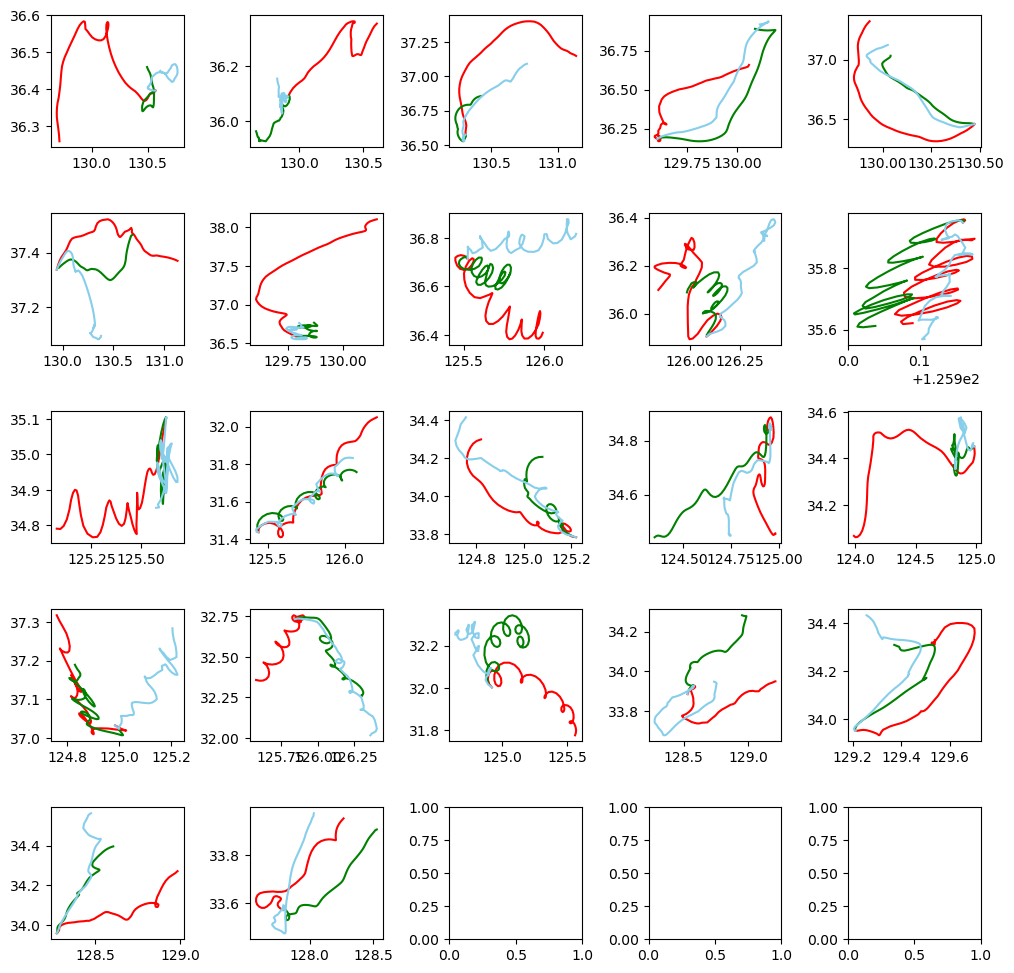

In [63]:
import sys
# MLP (activation relu) & roburst scaler & 특성 4 & 이전 연구 데이터 추가
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
      
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0) 
    
    # Test dataset
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)    
    
    MLP = tf.keras.Sequential([
    Dense(units = 40, input_dim = 4, activation = 'relu')
    ])
    MLP.add(Dense(units = 20, activation = 'relu'))
    MLP.add(Dense(units = 2))
    MLP.summary()
    MLP.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP.fit(train_X, train_y, epochs = 80, batch_size = 20)
    
    # model save
#     MLP.save(str(i)+'MLP_model.h5')

    # Predict
    y_pred = MLP.predict(test_X)
    np.set_printoptions(threshold=np.inf)
    
    # print(y_pred)
    # nan 값
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
      
    #mae
    # print(pred) nan 값
    print(drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print(NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [64]:
# MLP (activation relu) & roburst scaler & 특성 4 & 이전 연구 데이터 추가
MLP_mae_sum = 0
MLP_NCLS_sum = 0
for i in range(len(dataset)):
    MLP_mae_sum += MAE_list[i]
    MLP_NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', MLP_mae_sum/len(dataset) )
print ('평균 NCLS : ', MLP_NCLS_sum/len(dataset) )

평균 Mae :  0.19974289989313865
평균 NCLS :  0.46473482304146496


In [62]:
# MLP (activation relu) & roburst scaler & 특성 4 & 이전 연구 데이터 추가 (Hidden layer1_node : 30, Hidden layer2_node :15)
MLP_mae_sum = 0
MLP_NCLS_sum = 0
for i in range(len(dataset)):
    MLP_mae_sum += MAE_list[i]
    MLP_NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', MLP_mae_sum/len(dataset) )
print ('평균 NCLS : ', MLP_NCLS_sum/len(dataset) )

평균 Mae :  0.18211911535034478
평균 NCLS :  0.5210576314569796


--------------------- Model  0  ----------------------
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 12)                84        
                                                                 
 dense_133 (Dense)           (None, 6)                 78        
                                                                 
 dense_134 (Dense)           (None, 2)                 14        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 1s 1ms/step - loss: 0.0158 - mae: 0.0785
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0024 - mae: 0.0368
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0

93/93 [==============================] - 0s 1ms/step - loss: 1.6276e-04 - mae: 0.0103
Epoch 49/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6280e-04 - mae: 0.0103
Epoch 50/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6247e-04 - mae: 0.0103
Epoch 51/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6221e-04 - mae: 0.0103
Epoch 52/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6182e-04 - mae: 0.0103
Epoch 53/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6112e-04 - mae: 0.0103
Epoch 54/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6012e-04 - mae: 0.0102
Epoch 55/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5875e-04 - mae: 0.0102
Epoch 56/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5767e-04 - mae: 0.0101
Epoch 57/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5844e-04 - mae: 0.0102
Epoch 58/100
93/93 [===

 dense_141 (Dense)           (None, 12)                84        
                                                                 
 dense_142 (Dense)           (None, 6)                 78        
                                                                 
 dense_143 (Dense)           (None, 2)                 14        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 1s 1ms/step - loss: 0.0354 - mae: 0.1280
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0097 - mae: 0.0704
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0052 - mae: 0.0524
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0033 - mae: 0.0417
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0023 - mae: 0.0347
Epoc

93/93 [==============================] - 0s 1ms/step - loss: 1.5924e-04 - mae: 0.0102
Epoch 51/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5754e-04 - mae: 0.0101
Epoch 52/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5809e-04 - mae: 0.0101
Epoch 53/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5792e-04 - mae: 0.0101
Epoch 54/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5834e-04 - mae: 0.0101
Epoch 55/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5782e-04 - mae: 0.0101
Epoch 56/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5614e-04 - mae: 0.0100
Epoch 57/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5605e-04 - mae: 0.0100
Epoch 58/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5542e-04 - mae: 0.0100
Epoch 59/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5597e-04 - mae: 0.0100
Epoch 60/100
93/93 [===

 dense_151 (Dense)           (None, 6)                 78        
                                                                 
 dense_152 (Dense)           (None, 2)                 14        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 1s 1ms/step - loss: 0.2662 - mae: 0.2831
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0470 - mae: 0.1365
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0164 - mae: 0.0940
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0093 - mae: 0.0724
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0062 - mae: 0.0592
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0044 - mae: 0.0496
Epoch 7/100
93/93 [=======================

93/93 [==============================] - 0s 1ms/step - loss: 1.4963e-04 - mae: 0.0097
Epoch 53/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4923e-04 - mae: 0.0097
Epoch 54/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5050e-04 - mae: 0.0098
Epoch 55/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4894e-04 - mae: 0.0097
Epoch 56/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4816e-04 - mae: 0.0097
Epoch 57/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4761e-04 - mae: 0.0097
Epoch 58/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4892e-04 - mae: 0.0097
Epoch 59/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4582e-04 - mae: 0.0096
Epoch 60/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4780e-04 - mae: 0.0097
Epoch 61/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4827e-04 - mae: 0.0097
Epoch 62/100
93/93 [===

                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 1s 1ms/step - loss: 0.1571 - mae: 0.2587
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0262 - mae: 0.1082
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0125 - mae: 0.0821
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0077 - mae: 0.0660
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0052 - mae: 0.0532
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0036 - mae: 0.0431
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0025 - mae: 0.0351
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0017 - mae: 0.0288
Epoch 9/100
93/93 [==============================] -

93/93 [==============================] - 0s 1ms/step - loss: 1.5609e-04 - mae: 0.0099
Epoch 55/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5287e-04 - mae: 0.0097
Epoch 56/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5346e-04 - mae: 0.0098
Epoch 57/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5379e-04 - mae: 0.0098
Epoch 58/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5252e-04 - mae: 0.0098
Epoch 59/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5104e-04 - mae: 0.0097
Epoch 60/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5204e-04 - mae: 0.0097
Epoch 61/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5116e-04 - mae: 0.0097
Epoch 62/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5279e-04 - mae: 0.0098
Epoch 63/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5067e-04 - mae: 0.0097
Epoch 64/100
93/93 [===

_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 1s 1ms/step - loss: 0.0339 - mae: 0.1263
Epoch 2/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0075 - mae: 0.0621
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0034 - mae: 0.0428
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0332
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0014 - mae: 0.0275
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 0.0010 - mae: 0.0238
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 7.7319e-04 - mae: 0.0210
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 6.3035e-04 - mae: 0.0190
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 5.3668e-04 - mae: 0.0176
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 4.

93/93 [==============================] - 0s 1ms/step - loss: 1.7128e-04 - mae: 0.0106
Epoch 57/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7099e-04 - mae: 0.0105
Epoch 58/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7118e-04 - mae: 0.0106
Epoch 59/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6956e-04 - mae: 0.0105
Epoch 60/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6974e-04 - mae: 0.0105
Epoch 61/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6870e-04 - mae: 0.0105
Epoch 62/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6857e-04 - mae: 0.0105
Epoch 63/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6780e-04 - mae: 0.0104
Epoch 64/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6742e-04 - mae: 0.0104
Epoch 65/100
93/93 [==============================] - 0s 1ms/step - loss: 1.6647e-04 - mae: 0.0104
Epoch 66/100
93/93 [===

93/93 [==============================] - 0s 1ms/step - loss: 0.0016 - mae: 0.0276
Epoch 3/100
93/93 [==============================] - 0s 1ms/step - loss: 7.5019e-04 - mae: 0.0189
Epoch 4/100
93/93 [==============================] - 0s 1ms/step - loss: 4.6712e-04 - mae: 0.0156
Epoch 5/100
93/93 [==============================] - 0s 1ms/step - loss: 3.4732e-04 - mae: 0.0140
Epoch 6/100
93/93 [==============================] - 0s 1ms/step - loss: 2.8692e-04 - mae: 0.0130
Epoch 7/100
93/93 [==============================] - 0s 1ms/step - loss: 2.5320e-04 - mae: 0.0123
Epoch 8/100
93/93 [==============================] - 0s 1ms/step - loss: 2.3038e-04 - mae: 0.0119
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 2.1370e-04 - mae: 0.0115
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 2.0237e-04 - mae: 0.0112
Epoch 11/100
93/93 [==============================] - 0s 1ms/step - loss: 1.9448e-04 - mae: 0.0111
Epoch 12/100
93/93 [==============

Epoch 85/100
93/93 [==============================] - 0s 1ms/step - loss: 9.4651e-05 - mae: 0.0076
Epoch 86/100
93/93 [==============================] - 0s 1ms/step - loss: 9.4191e-05 - mae: 0.0076
Epoch 87/100
93/93 [==============================] - 0s 1ms/step - loss: 9.3216e-05 - mae: 0.0075
Epoch 88/100
93/93 [==============================] - 0s 1ms/step - loss: 9.3352e-05 - mae: 0.0075
Epoch 89/100
93/93 [==============================] - 0s 1ms/step - loss: 9.1868e-05 - mae: 0.0075
Epoch 90/100
93/93 [==============================] - 0s 1ms/step - loss: 9.1277e-05 - mae: 0.0074
Epoch 91/100
93/93 [==============================] - 0s 1ms/step - loss: 9.1915e-05 - mae: 0.0075
Epoch 92/100
93/93 [==============================] - 0s 1ms/step - loss: 9.0352e-05 - mae: 0.0074
Epoch 93/100
93/93 [==============================] - 0s 1ms/step - loss: 9.1181e-05 - mae: 0.0074
Epoch 94/100
93/93 [==============================] - 0s 1ms/step - loss: 8.8124e-05 - mae: 0.0073
Epoch 95/1

93/93 [==============================] - 0s 1ms/step - loss: 1.5645e-04 - mae: 0.0098
Epoch 32/100
93/93 [==============================] - 0s 1ms/step - loss: 1.5249e-04 - mae: 0.0097
Epoch 33/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4819e-04 - mae: 0.0096
Epoch 34/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4637e-04 - mae: 0.0095
Epoch 35/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4424e-04 - mae: 0.0095
Epoch 36/100
93/93 [==============================] - 0s 1ms/step - loss: 1.4057e-04 - mae: 0.0094
Epoch 37/100
93/93 [==============================] - 0s 1ms/step - loss: 1.3662e-04 - mae: 0.0092
Epoch 38/100
93/93 [==============================] - 0s 1ms/step - loss: 1.3579e-04 - mae: 0.0092
Epoch 39/100
93/93 [==============================] - 0s 1ms/step - loss: 1.3153e-04 - mae: 0.0090
Epoch 40/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2999e-04 - mae: 0.0090
Epoch 41/100
93/93 [===

Epoch 87/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2346e-04 - mae: 0.0088
Epoch 88/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2334e-04 - mae: 0.0088
Epoch 89/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2241e-04 - mae: 0.0088
Epoch 90/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2260e-04 - mae: 0.0088
Epoch 91/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2344e-04 - mae: 0.0088
Epoch 92/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2323e-04 - mae: 0.0088
Epoch 93/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2341e-04 - mae: 0.0088
Epoch 94/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2179e-04 - mae: 0.0087
Epoch 95/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2263e-04 - mae: 0.0088
Epoch 96/100
93/93 [==============================] - 0s 1ms/step - loss: 1.2158e-04 - mae: 0.0087
Epoch 97/1

93/93 [==============================] - 0s 1ms/step - loss: 1.7817e-04 - mae: 0.0108
Epoch 34/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7716e-04 - mae: 0.0107
Epoch 35/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7702e-04 - mae: 0.0107
Epoch 36/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7655e-04 - mae: 0.0107
Epoch 37/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7643e-04 - mae: 0.0107
Epoch 38/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7808e-04 - mae: 0.0108
Epoch 39/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7569e-04 - mae: 0.0106
Epoch 40/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7556e-04 - mae: 0.0107
Epoch 41/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7527e-04 - mae: 0.0106
Epoch 42/100
93/93 [==============================] - 0s 1ms/step - loss: 1.7498e-04 - mae: 0.0106
Epoch 43/100
93/93 [===

Epoch 89/100
93/93 [==============================] - 0s 1ms/step - loss: 8.9000e-05 - mae: 0.0072
Epoch 90/100
93/93 [==============================] - 0s 1ms/step - loss: 8.9257e-05 - mae: 0.0073
Epoch 91/100
93/93 [==============================] - 0s 1ms/step - loss: 8.8837e-05 - mae: 0.0073
Epoch 92/100
93/93 [==============================] - 0s 1ms/step - loss: 8.7708e-05 - mae: 0.0072
Epoch 93/100
93/93 [==============================] - 0s 1ms/step - loss: 8.8321e-05 - mae: 0.0072
Epoch 94/100
93/93 [==============================] - 0s 1ms/step - loss: 8.6513e-05 - mae: 0.0071
Epoch 95/100
93/93 [==============================] - 0s 1ms/step - loss: 8.7484e-05 - mae: 0.0072
Epoch 96/100
93/93 [==============================] - 0s 1ms/step - loss: 8.6601e-05 - mae: 0.0071
Epoch 97/100
93/93 [==============================] - 0s 1ms/step - loss: 8.7235e-05 - mae: 0.0071
Epoch 98/100
93/93 [==============================] - 0s 1ms/step - loss: 8.5857e-05 - mae: 0.0071
Epoch 99/1

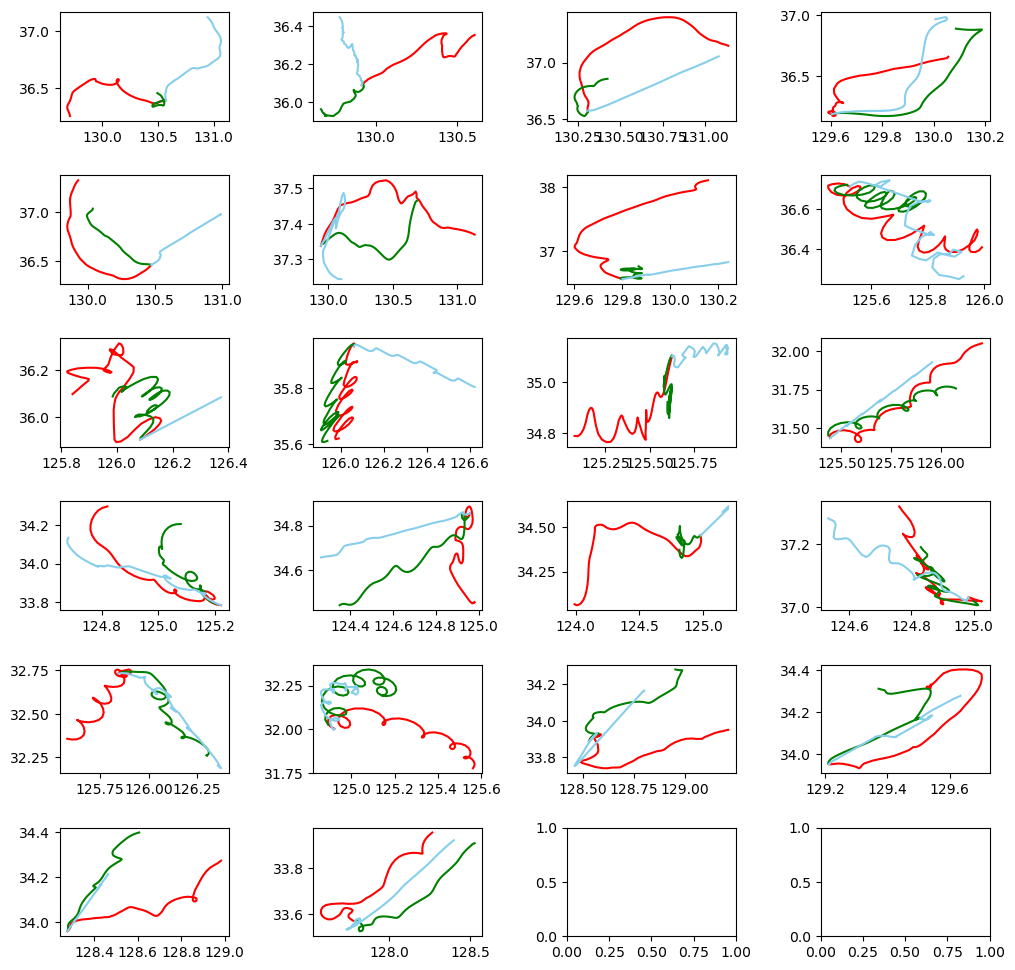

In [9]:
# MLP 특성 6
f, axes = plt.subplots(6, 4)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','start_lon','start_lat']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)    # 선형모델 생성
    
    MLP = tf.keras.Sequential([
    Dense(units = 30, input_dim = 6, activation = relu)
    ])
    MLP.add(Dense(units = 15, activation = relu))
    MLP.add(Dense(units = 2))
    MLP.summary()
    MLP.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP.fit(train_X, train_y, epochs = 100, batch_size = 30)
    
    # model save
#     MLP.save(str(i)+'MLP_model.h5')

    # Predict
    y_pred = MLP.predict(test_X)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//4
    col = i%4
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print(drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print(NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [10]:
MLP_mae_sum = 0
MLP_NCLS_sum = 0
for i in range(len(dataset)):
    MLP_mae_sum += MAE_list[i]
    MLP_NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', MLP_mae_sum/len(dataset) )
print ('평균 NCLS : ', MLP_NCLS_sum/len(dataset) )

평균 Mae :  0.2198041137746789
평균 NCLS :  0.41351460481471203
